In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import pyabc

import parallel

In [2]:
cov = sp.array([[.5, 0],
                [0, .5]])
cov

array([[ 0.5,  0. ],
       [ 0. ,  0.5]])

In [3]:
data = sp.array([1, 1])
data

array([1, 1])

In [4]:
def p(x, theta):
    return 1/ sp.pi * sp.exp(-((x-theta**2)**2).sum(axis=-1))

In [5]:
MAX_SIZE = 2

In [6]:
TX, TY = sp.meshgrid(sp.linspace(-MAX_SIZE, MAX_SIZE, 200), sp.linspace(-MAX_SIZE, MAX_SIZE, 200))

In [7]:
TXY = sp.stack((TX, TY), axis=2)

In [8]:
density = p(TXY, sp.array([0, 0]))

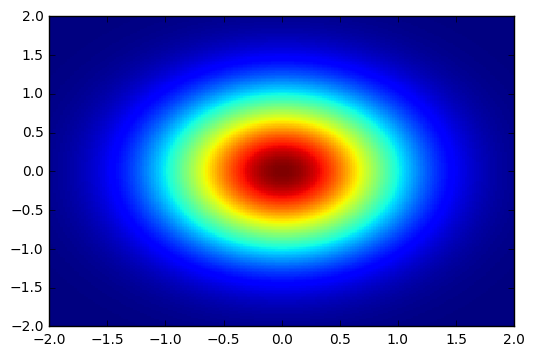

In [9]:
plt.pcolor(TX, TY, density);

In [10]:
def prior(theta):
    return 1/20**2 * ((-MAX_SIZE < theta) & (theta < MAX_SIZE)).all(axis=-1).astype(float)

In [11]:
def posterior(theta, data):
    return p(data, theta) * prior(theta)

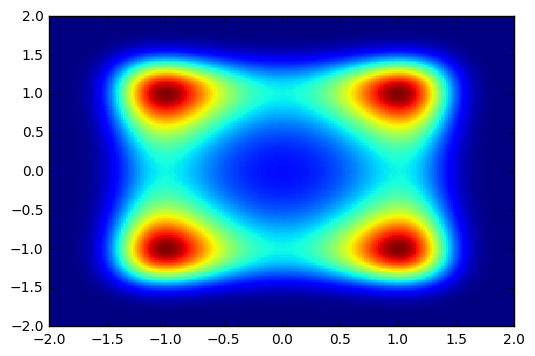

In [12]:
plt.pcolor(TX, TY, posterior(TXY, data));

In [13]:
def abc_model(args):
    theta_squared = sp.array([args.theta1, args.theta2])
    sample = sp.random.multivariate_normal(theta_squared, cov)
    return {"x": sample[0], "y": sample[1]}

In [14]:
class ABCPrior:
    def pdf(self, x):
        return prior(sp.array([x.theta1, x.theta2]))
    
    def rvs(self):
        sample = sp.rand(2) * 2 * MAX_SIZE - MAX_SIZE
        return pyabc.Parameter({"theta1": sample[0], "theta2": sample[1]})

In [15]:
model_prior = pyabc.RV("randint", 0, 1)
population_size = pyabc.populationstrategy.ConstantPopulationStrategy(2000, 5)

In [16]:
mapper = parallel.SGE().map if parallel.sge_evailable() else map
abc = pyabc.ABCSMC([pyabc.SimpleModel(abc_model)],
                    model_prior,
                    pyabc.ModelPerturbationKernel(1, probability_to_stay=.8),
                    [ABCPrior()],
                    [pyabc.MultivariateNormalTransition()],
                    pyabc.PercentileDistanceFunction(measures_to_use=["x", "y"]),
                    pyabc.MedianEpsilon(.1),
                    population_size,
                    sampler=parallel.sampler.MappingSampler(map=mapper))
abc.stop_if_only_single_model_alive = False

DEBUG:Epsilon:init medianepsilon initial_epsilon=0.1, median_multiplier=1


In [17]:
options = {'db_path': "sqlite:////home/emmanuel/tmp/testabc.db"}
abc.set_data({"x": 1, "y": 1}, 0, {}, options)

DEBUG:Epsilon:calc initial epsilon
DEBUG:Epsilon:initial epsilon is 0.1


In [18]:
history = abc.run(.01)

DEBUG:ABC:t:0 eps:0.1
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 298478
DEBUG:Epsilon:new eps, t=1, eps=0.06979496618629648
DEBUG:ABC:t:1 eps:0.06979496618629648
DEBUG:ABC:now submitting population 1


KeyboardInterrupt: 

In [19]:
points_theta1, weights_theta_1 =  history.get_results_distribution(0, "theta1")
points_theta2, weights_theta_2 = history.get_results_distribution(0, "theta2")

NameError: name 'history' is not defined

In [ ]:
hist, xedges, yedges = sp.histogram2d(points_theta1, points_theta2, weights=weights_theta_1, bins=30);

In [ ]:
xedges_mesh, yedges_mesh = sp.meshgrid(xedges[:-1], yedges[:-1])

In [ ]:
plt.pcolor(xedges_mesh, yedges_mesh, hist)